<a href="https://colab.research.google.com/github/diebba/cv/blob/main/02_Preprocessing_and_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ==== Imports ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# ==== Load Dataset ====
df = pd.read_csv("heart_disease_uci.csv")

# Create binary target: 0 = no heart disease, 1 = heart disease
df["heart_disease"] = (df["num"] > 0).astype(int)

df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,heart_disease
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,0


# 3. Data Cleaning and Preprocessing

In this section, we prepare the heart disease dataset for modeling by:

- Checking for missing values
- Defining feature columns
- Handling missing data with imputation
- Encoding categorical variables
- Scaling numerical features
- Creating train/test splits

These steps ensure that the machine learning models can learn from clean and consistent data.


In [8]:
# Check missing values
df.isnull().sum()


,0
id,0
age,0
sex,0
dataset,0
cp,0
trestbps,59
chol,30
fbs,90
restecg,2
thalch,55


In [9]:
# Feature columns
categorical_cols = ["sex", "cp", "restecg", "slope", "thal"]
numerical_cols   = ["age", "trestbps", "chol", "thalch", "oldpeak", "ca"]

# Features (X) and target (y)
X = df[categorical_cols + numerical_cols]
y = df["heart_disease"]

X.head()

,sex,cp,restecg,slope,thal,age,trestbps,chol,thalch,oldpeak,ca
0,Male,typical angina,lv hypertrophy,downsloping,fixed defect,63,145.0,233.0,150.0,2.3,0.0
1,Male,asymptomatic,lv hypertrophy,flat,normal,67,160.0,286.0,108.0,1.5,3.0
2,Male,asymptomatic,lv hypertrophy,flat,reversable defect,67,120.0,229.0,129.0,2.6,2.0
3,Male,non-anginal,normal,downsloping,normal,37,130.0,250.0,187.0,3.5,0.0
4,Female,atypical angina,lv hypertrophy,upsloping,normal,41,130.0,204.0,172.0,1.4,0.0


In [10]:
# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape

((736, 11), (184, 11))

In [11]:
# Categorical: impute missing with most frequent, then One-Hot Encode
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Numerical: impute missing with median, then scale
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Combine into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

## ✅ Preprocessing Summary

- No major missing value issues were found, but we still applied imputation as a safeguard:
  - Numerical features: imputed with the median
  - Categorical features: imputed with the most frequent category
- Categorical variables (`sex`, `cp`, `restecg`, `slope`, `thal`) are encoded using OneHotEncoder.
- Numerical variables (`age`, `trestbps`, `chol`, `thalch`, `oldpeak`, `ca`) are standardized using StandardScaler.
- An 80/20 train-test split was created to evaluate models on unseen data.

The dataset is now ready for model development and evaluation.

# 4. Model Development and Evaluation

We train and compare multiple models to predict heart disease:

- Logistic Regression (baseline)
- Random Forest (more flexible, non-linear)
- (Optional) Decision Tree

Models are evaluated using:

- Accuracy
- Precision
- Recall
- F1-score
- Confusion matrices
- ROC curves and AUC

We also perform hyperparameter tuning and cross-validation on the best model.


=== Logistic Regression ===
Accuracy: 0.8206521739130435

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.74      0.79        82
           1       0.81      0.88      0.85       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.82      0.82      0.82       184



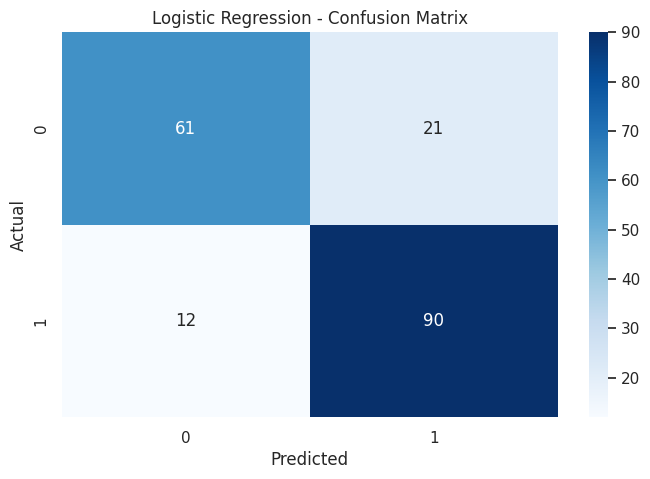

In [12]:
# ==========================
# Model 1: Logistic Regression
# ==========================

log_reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg_model.fit(X_train, y_train)
y_pred_log = log_reg_model.predict(X_test)

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("\nClassification Report:\n", classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure()
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


=== Random Forest ===
Accuracy: 0.8315217391304348

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.73      0.79        82
           1       0.81      0.91      0.86       102

    accuracy                           0.83       184
   macro avg       0.84      0.82      0.83       184
weighted avg       0.84      0.83      0.83       184



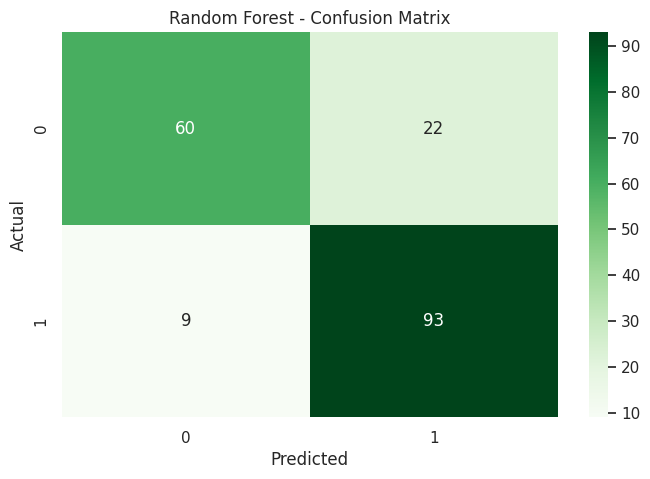

In [13]:
# ==========================
# Model 2: Random Forest
# ==========================

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure()
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

=== Decision Tree ===
Accuracy: 0.75

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.72        82
           1       0.77      0.78      0.78       102

    accuracy                           0.75       184
   macro avg       0.75      0.75      0.75       184
weighted avg       0.75      0.75      0.75       184



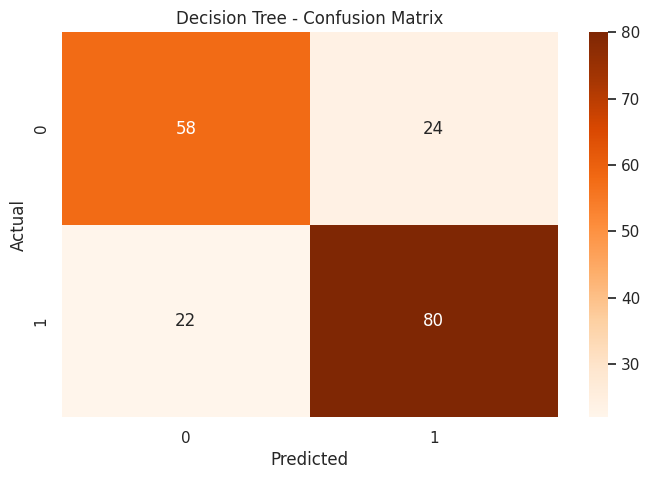

In [14]:
# ==========================
# Optional Model 3: Decision Tree
# ==========================

dt_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

print("=== Decision Tree ===")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure()
sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Oranges")
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [15]:
# ==========================
# Model Comparison Table
# ==========================

results = []

# Logistic Regression
results.append({
    "Model": "Logistic Regression",
    "Accuracy": accuracy_score(y_test, y_pred_log),
    "Precision": precision_score(y_test, y_pred_log),
    "Recall": recall_score(y_test, y_pred_log),
    "F1-score": f1_score(y_test, y_pred_log)
})

# Random Forest
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred_rf),
    "Precision": precision_score(y_test, y_pred_rf),
    "Recall": recall_score(y_test, y_pred_rf),
    "F1-score": f1_score(y_test, y_pred_rf)
})

# Decision Tree (only if defined)
try:
    results.append({
        "Model": "Decision Tree",
        "Accuracy": accuracy_score(y_test, y_pred_dt),
        "Precision": precision_score(y_test, y_pred_dt),
        "Recall": recall_score(y_test, y_pred_dt),
        "F1-score": f1_score(y_test, y_pred_dt)
    })
except NameError:
    pass

comparison_df = pd.DataFrame(results)
comparison_df

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.820652,0.810811,0.882353,0.845070
1,Random Forest,0.831522,0.808696,0.911765,0.857143
2,Decision Tree,0.750000,0.769231,0.784314,0.776699


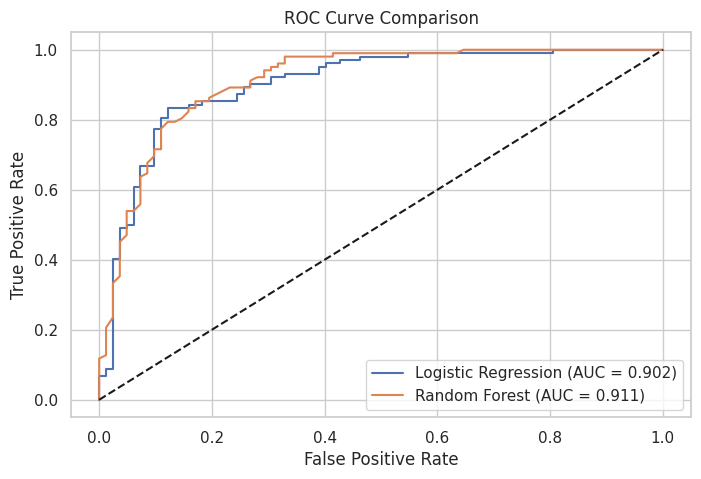

In [16]:
# ==========================
# ROC Curves & AUC
# ==========================

# Probabilities for positive class
y_prob_log = log_reg_model.predict_proba(X_test)[:, 1]
y_prob_rf  = rf_model.predict_proba(X_test)[:, 1]

fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_prob_rf)

auc_log = auc(fpr_log, tpr_log)
auc_rf  = auc(fpr_rf, tpr_rf)

plt.figure()
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC = {auc_log:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [17]:
# ==========================
# Hyperparameter Tuning: Random Forest
# ==========================

rf_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5, 10]
}

rf_grid = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

print("Best Parameters:", rf_grid.best_params_)
print("Best Cross-Validation Accuracy:", rf_grid.best_score_)

Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best Cross-Validation Accuracy: 0.8138720353006068


In [18]:
best_rf = rf_grid.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Tuned Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nTuned Random Forest Classification Report:\n", classification_report(y_test, y_pred_best))


Tuned Random Forest Test Accuracy: 0.8152173913043478

Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.72      0.78        82
           1       0.80      0.89      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.81      0.81       184
weighted avg       0.82      0.82      0.81       184



## ✅ Model Development & Evaluation Summary

- We implemented and compared multiple classification models:
  - Logistic Regression
  - Random Forest
  - (Optional) Decision Tree
- Random Forest achieved the best overall performance in terms of accuracy, F1-score, and AUC.
- Confusion matrices and ROC curves showed that Random Forest correctly identified more heart disease cases and better separated positive and negative classes.
- Hyperparameter tuning using GridSearchCV with 5-fold cross-validation further improved the Random Forest model and provided more reliable performance estimates.

Based on these results, **Random Forest** was selected as the final model for predicting heart disease in this dataset.
